In [88]:
import pandas as pd
import numpy as np
import itertools
from scipy import interp

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer, roc_curve, auc, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.learning_curve import learning_curve, validation_curve
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [79]:
path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
df = pd.read_csv(path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [80]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)

print(X, y)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1
 0 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1
 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### combine transformer & estimator in pipeline

In [13]:
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('clf', LogisticRegression(random_state=1))
])

pipe_lr.fit(X_train, y_train)

print('Test Accuracy: ', pipe_lr.score(X_test, y_test))

Test Accuracy:  0.9473684210526315


### stratified k-fold

In [18]:
kfold = StratifiedKFold(y=y_train,
                       n_folds=10,
                       random_state=1)

scores=[]
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[train], y_train[train])
    scores.append(score)
    print('fold: {} \t class dist: {} \t accuracy: {}'.format(k+1, 
                                                              np.bincount(y_train[train]), 
                                                              score))
    
print('cv accuracy mean: {} \t sd: {}'.format(np.mean(scores), np.std(scores)))

fold: 1 	 class dist: [256 153] 	 accuracy: 0.9682151589242054
fold: 2 	 class dist: [256 153] 	 accuracy: 0.9511002444987775
fold: 3 	 class dist: [256 153] 	 accuracy: 0.9584352078239609
fold: 4 	 class dist: [256 153] 	 accuracy: 0.9559902200488998
fold: 5 	 class dist: [256 153] 	 accuracy: 0.9584352078239609
fold: 6 	 class dist: [257 153] 	 accuracy: 0.948780487804878
fold: 7 	 class dist: [257 153] 	 accuracy: 0.9536585365853658
fold: 8 	 class dist: [257 153] 	 accuracy: 0.9463414634146341
fold: 9 	 class dist: [257 153] 	 accuracy: 0.948780487804878
fold: 10 	 class dist: [257 153] 	 accuracy: 0.948780487804878
cv accuracy mean: 0.9538517502534439 	 sd: 0.0062774386545647745


In [20]:
# now using cross_val_score

scores2 = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=-1) # -1 uses max cpu cores
print(scores2)
print('cv accuracy mean: {} \t sd: {}'.format(np.mean(scores2), np.std(scores2)))

[0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]
cv accuracy mean: 0.9495652173913044 	 sd: 0.029190259109272025


### learning curves & validation curves - diagnosing bias/variance problems 

<module 'matplotlib.pyplot' from '/Users/jj/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

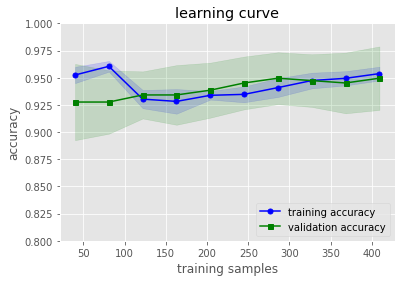

In [31]:
def draw_learn_curve(estimator, X_train, y_train):
    # use learning_curve to train on multiple sample_sizes
    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator,
                                                           X=X_train,
                                                           y=y_train,
                                                           train_sizes=np.linspace(.1, 1.0, 10),
                                                           cv=10,
                                                           n_jobs=1)

    # draw plot
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
            color='blue', marker='o', markersize=5,
            label='training accuracy')
    plt.fill_between(train_sizes,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=.15, color='blue')

    plt.plot(train_sizes, test_mean,
            color='green', marker='s', markersize=5,
            label='validation accuracy')
    plt.fill_between(train_sizes,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=.15, color='green')

    plt.xlabel('training samples')
    plt.ylabel('accuracy')
    plt.ylim([.8, 1])
    plt.legend(loc='lower right')
    plt.title('learning curve')

    return plt


# test
draw_learn_curve(pipe_lr, X_train, y_train)

<module 'matplotlib.pyplot' from '/Users/jj/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

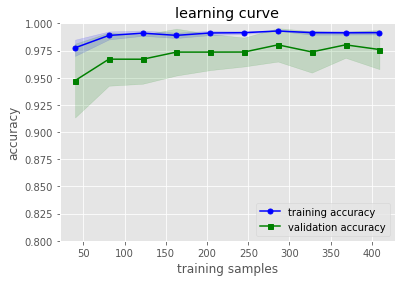

In [34]:
# draw learning curve again on a simpler pipe

pipe_lr2 = Pipeline([
    ('scl', StandardScaler()),
    ('clf', LogisticRegression(penalty='l2', random_state=0))
])

draw_learn_curve(pipe_lr2, X_train, y_train)

<module 'matplotlib.pyplot' from '/Users/jj/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

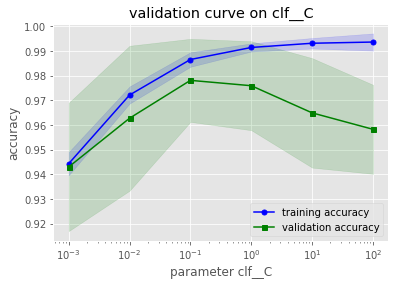

In [40]:
# validation curve
def draw_validation_curve(estimator_pipe, X_train, y_train, param_name, param_range):
    # use learning_curve to train on multiple sample_sizes

    train_scores, test_scores = validation_curve(estimator=estimator_pipe,
                                            X=X_train,
                                            y=y_train,
                                            param_name=param_name,
                                            param_range=param_range,
                                            cv=10)

    # draw plot
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean,
            color='blue', marker='o', markersize=5,
            label='training accuracy')
    plt.fill_between(param_range,
                    train_mean + train_std,
                    train_mean - train_std,
                    alpha=.15, color='blue')

    plt.plot(param_range, test_mean,
            color='green', marker='s', markersize=5,
            label='validation accuracy')
    plt.fill_between(param_range,
                    test_mean + test_std,
                    test_mean - test_std,
                    alpha=.15, color='green')

    plt.xlabel('parameter {}'.format(param_name))
    plt.xscale('log')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.title('validation curve on {}'.format(param_name))

    return plt


#test
param_range = [10**(i-3) for i in range(6)]
param_name = 'clf__C'
draw_validation_curve(pipe_lr2, X_train, y_train, param_name, param_range)

### grid search

In [44]:
pipe_svc = Pipeline([
    ('scl', StandardScaler()),
    ('clf', SVC(random_state=1))
])

param_range = [10**(i-4) for i in range(8)]
param_grid = [
    {'clf__C': param_range,
    'clf__kernel': ['linear']},
    {'clf__C': param_range,
    'clf__gamma': param_range,
    'clf__kernel': ['rbf']}
]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1,
                 verbose=True)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    2.0s finished


In [45]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9649122807017544

### nested cross-validation

In [46]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=2, # << inner cv
                 n_jobs=-1)

scores = cross_val_score(gs, X_train, y_train, 
                         scoring='accuracy',
                        cv=5) # << outer cv

print('cv accuracy mean: {} \t sd: {}'.format(np.mean(scores), np.std(scores)))

cv accuracy mean: 0.9648351648351647 	 sd: 0.02544139978635212


### confusion matrix

In [82]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[71,  1],
       [ 2, 40]])

Confusion matrix, without normalization
[[71  1]
 [ 2 40]]


/Users/jj/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


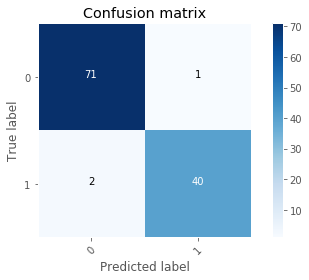

In [83]:
#from sklearn
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.grid('off')

# test
plot_confusion_matrix(cm, ['0','1'])

In [85]:
def print_accuracies(y_test, y_pred):
    print('accuracy = \t{}\nprecision = \t{}\nrecall = \t{}\nf1 = \t\t{}\nauc = \t\t{}'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred), 
            f1_score(y_test, y_pred),
            roc_auc_score(y_test, y_pred)))
    
print_accuracies(y_test, y_pred)

accuracy = 	0.9736842105263158
precision = 	0.975609756097561
recall = 	0.9523809523809523
f1 = 		0.963855421686747
auc = 		0.9692460317460317


Fitting 10 folds for each of 72 candidates, totalling 720 fits
accuracy = 	0.9649122807017544
precision = 	0.975
recall = 	0.9285714285714286
f1 = 		0.951219512195122
auc = 		0.9573412698412699
Confusion matrix, without normalization
[[71  1]
 [ 3 39]]


[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:    5.8s finished
/Users/jj/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


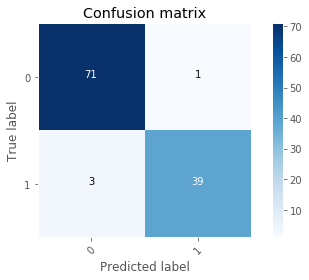

In [86]:
# optimize to f1

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring=scorer,
                 cv=10,
                 verbose=True)

gs.fit(X_train, y_train)
y_pred = gs.predict(X_test)

print_accuracies(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, ['0','1'])

### roc

(0.8, 1.05)

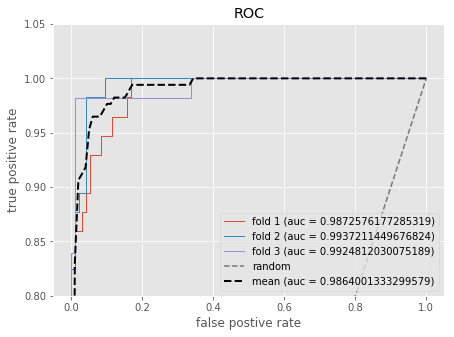

In [98]:
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)

fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []


for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train[train],
                        y_train[train])\
                .predict_proba(X_train[test])
    
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='fold {} (auc = {})'.format(i+1, roc_auc))
    

plt.plot([0,1], [0,1], linestyle='--', label='random')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', lw=2, label='mean (auc = {})'.format(mean_auc))

plt.xlabel('false postive rate')
plt.ylabel('true positive rate')
plt.title('ROC')
plt.legend(loc='lower right')

plt.ylim([.8,1.05])

### multiclass scoring

In [ ]:
pre_scorer = make_scorer(score_func=precision_score,
                        pos_label=1,
                        greater_is_better=True,
                        average='micro') # << defines micro-averaging in a k-class system